# かがわAIゼミナール通し課題 KickstarterProjects
クラウドファンディング実施前に成功/失敗を予測するモデルを作成する

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数
from sklearn.model_selection import train_test_split
import datetime as dt

読み込み直後の件数
378661
データ精査後の件数
374860


failed        197611
successful    133851
canceled       38757
live            2798
suspended       1843
Name: state, dtype: int64

ステータスをsuccessful、failedに絞った件数
331462


,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,funding_term
0,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11,0.0,failed,0,GB,0.0,0.0,1533.95,59
1,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02,2421.0,failed,15,US,100.0,2421.0,30000.00,60
2,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12,220.0,failed,3,US,220.0,220.0,45000.00,45
3,Music,Music,USD,2012-04-16,5000.0,2012-03-17,1.0,failed,1,US,1.0,1.0,5000.00,30
5,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26,52375.0,successful,224,US,52375.0,52375.0,50000.00,35


,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real,funding_term
goal,1.000000,0.007962,0.004792,0.006416,0.005949,0.952614,0.022696
pledged,0.007962,1.000000,0.718120,0.857966,0.953465,0.005716,0.008036
backers,0.004792,0.718120,1.000000,0.697493,0.753221,0.005207,-0.000059
usd pledged,0.006416,0.857966,0.697493,1.000000,0.907713,0.006965,0.007718
usd_pledged_real,0.005949,0.953465,0.753221,0.907713,1.000000,0.006349,0.008570
usd_goal_real,0.952614,0.005716,0.005207,0.006965,0.006349,1.000000,0.021611
funding_term,0.022696,0.008036,-0.000059,0.007718,0.008570,0.021611,1.000000


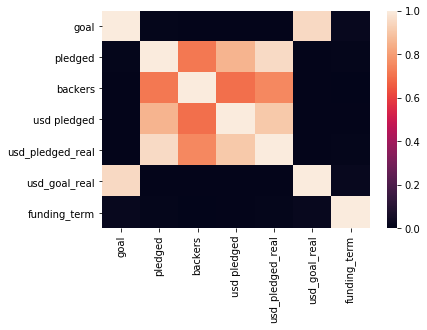

In [2]:
#データ読み込み
df_ksproj = pd.read_csv("./ks-projects-201801/ks-projects-201801.csv")

print("読み込み直後の件数")
print(len(df_ksproj))

#不要なデータ/欠損値の削除
#display(df_ksproj.isnull().sum())
#display(df_ksproj.dtypes)
#行中に一つでも欠損値があるデータを取り除く
df_ksproj = df_ksproj.dropna(how='any')

print("データ精査後の件数")
print(len(df_ksproj))

#成功失敗の出現数カウント
display(df_ksproj['state'].value_counts())
#canceled ・・・キャンセル
#undefined ・・・未定義
#live ・・・生きている(進行中)
#suspended ・・・中断

#大半がfailedとsuccessfulのため、それ以外はいったん無視する
df_ksproj = df_ksproj[df_ksproj['state'].isin(["successful", "failed"])]

print("ステータスをsuccessful、failedに絞った件数")
print(len(df_ksproj))

#クラウドファンディング開始～終了までの期間が長ければ成功しやすくなると仮定して、launchedとdeadlineの差を計算する

#日付データをobject型からdatetime型に変換する
df_ksproj['deadline'] = pd.to_datetime(df_ksproj['deadline'])
#launchedから時刻を取り除く
df_ksproj['launched'] = pd.to_datetime(df_ksproj['launched']).dt.date
df_ksproj['launched'] = pd.to_datetime(df_ksproj['launched'])
#クラウドファンディング期間を数値型で用意したfunding_termをデータフレームに追加する
df_ksproj['funding_term'] = df_ksproj['deadline'] - df_ksproj['launched']
df_ksproj['funding_term'] = (df_ksproj['funding_term'] / np.timedelta64(1, 'D')).astype(int)
#不要な列 IDとnameを削除する
df_ksproj = df_ksproj.drop(['ID','name'], axis=1)

display(df_ksproj.head(5))
#df_ksproj.describe()

#相関関数を表示
display(df_ksproj.corr())

#ヒートマップを表示
sns.heatmap(df_ksproj.corr())

In [3]:
#メインカテゴリごとに成功率を出してみる
#カテゴリはメインカテゴリと似ているが、細かすぎるので使わない
df_ksproj_groupbycategoryAndstate = df_ksproj.groupby(['main_category', 'state']).size()
print("カテゴリごとのsuccessfulとfailedの件数")
display(df_ksproj_groupbycategoryAndstate)

ArtSucPer = df_ksproj_groupbycategoryAndstate['Art','successful']/df_ksproj_groupbycategoryAndstate['Art'].sum()
print("Art Success:{}%".format(math.ceil(ArtSucPer*100)))
ComicsSucPer = df_ksproj_groupbycategoryAndstate['Comics','successful']/df_ksproj_groupbycategoryAndstate['Comics'].sum()
print("Comics Success:{}%".format(math.ceil(ComicsSucPer*100)))
CraftsSucPer = df_ksproj_groupbycategoryAndstate['Crafts','successful']/df_ksproj_groupbycategoryAndstate['Crafts'].sum()
print("Crafts Success:{}%".format(math.ceil(CraftsSucPer*100)))
DanceSucPer = df_ksproj_groupbycategoryAndstate['Dance','successful']/df_ksproj_groupbycategoryAndstate['Dance'].sum()
print("Dance Success:{}%".format(math.ceil(DanceSucPer*100)))
DesignSucPer = df_ksproj_groupbycategoryAndstate['Design','successful']/df_ksproj_groupbycategoryAndstate['Design'].sum()
print("Design Success:{}%".format(math.ceil(DesignSucPer*100)))
FashionSucPer = df_ksproj_groupbycategoryAndstate['Fashion','successful']/df_ksproj_groupbycategoryAndstate['Fashion'].sum()
print("Fashion Success:{}%".format(math.ceil(FashionSucPer*100)))
FilmAndVideoSucPer = df_ksproj_groupbycategoryAndstate['Film & Video','successful']/df_ksproj_groupbycategoryAndstate['Film & Video'].sum()
print("FilmAndVideo Success:{}%".format(math.ceil(FilmAndVideoSucPer*100)))
FoodSucPer = df_ksproj_groupbycategoryAndstate['Food','successful']/df_ksproj_groupbycategoryAndstate['Food'].sum()
print("Food Success:{}%".format(math.ceil(FoodSucPer*100)))
GamesSucPer = df_ksproj_groupbycategoryAndstate['Games','successful']/df_ksproj_groupbycategoryAndstate['Games'].sum()
print("Games Success:{}%".format(math.ceil(GamesSucPer*100)))
JournalismSucPer = df_ksproj_groupbycategoryAndstate['Journalism','successful']/df_ksproj_groupbycategoryAndstate['Journalism'].sum()
print("Journalism Success:{}%".format(math.ceil(JournalismSucPer*100)))
MusicSucPer = df_ksproj_groupbycategoryAndstate['Music','successful']/df_ksproj_groupbycategoryAndstate['Music'].sum()
print("Music Success:{}%".format(math.ceil(MusicSucPer*100)))
PhotographySucPer = df_ksproj_groupbycategoryAndstate['Photography','successful']/df_ksproj_groupbycategoryAndstate['Photography'].sum()
print("Photography Success:{}%".format(math.ceil(PhotographySucPer*100)))
PublishingSucPer = df_ksproj_groupbycategoryAndstate['Publishing','successful']/df_ksproj_groupbycategoryAndstate['Publishing'].sum()
print("Publishing Success:{}%".format(math.ceil(PublishingSucPer*100)))
TechnologySucPer = df_ksproj_groupbycategoryAndstate['Technology','successful']/df_ksproj_groupbycategoryAndstate['Technology'].sum()
print("Technology Success:{}%".format(math.ceil(TechnologySucPer*100)))
TheaterSucPer = df_ksproj_groupbycategoryAndstate['Theater','successful']/df_ksproj_groupbycategoryAndstate['Theater'].sum()
print("Theater Success:{}%".format(math.ceil(TheaterSucPer*100)))

#成功しやすいメインカテゴリの区分をデータフレームに追加する(Success > 50%のメインカテゴリ)
#対象のメインカテゴリ Comics 60% Dance 66% Music 53% Theater 64%
df_ksproj = df_ksproj.assign(SuccessHighCategory = 0)
df_ksproj.loc[df_ksproj['main_category'].isin(['Comics', 'Dance', 'Music', 'Theater']),'SuccessHighCategory'] = 1

#display(df_ksproj.head(5))


カテゴリごとのsuccessfulとfailedの件数


main_category  state     
Art            failed        14130
               successful    11510
Comics         failed         4036
               successful     5842
Crafts         failed         5703
               successful     2115
Dance          failed         1235
               successful     2338
Design         failed        14814
               successful    10549
Fashion        failed        14181
               successful     5593
Film & Video   failed        32891
               successful    23612
Food           failed        15969
               successful     6085
Games          failed        16002
               successful    12518
Journalism     failed         3136
               successful     1012
Music          failed        21696
               successful    24105
Photography    failed         6384
               successful     3305
Publishing     failed        23113
               successful    12300
Technology     failed        20613
               successful    

Art Success:45%
Comics Success:60%
Crafts Success:28%
Dance Success:66%
Design Success:42%
Fashion Success:29%
FilmAndVideo Success:42%
Food Success:28%
Games Success:44%
Journalism Success:25%
Music Success:53%
Photography Success:35%
Publishing Success:35%
Technology Success:24%
Theater Success:64%


,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,funding_term,SuccessHighCategory
0,108,12,5,2015-10-09,1000.0,2015-08-11,0.0,0,0,9,0.0,0.0,1533.95,59,0
1,93,6,13,2017-11-01,30000.0,2017-09-02,2421.0,0,15,21,100.0,2421.0,30000.00,60,0
2,93,6,13,2013-02-26,45000.0,2013-01-12,220.0,0,3,21,220.0,220.0,45000.00,45,0
3,90,10,13,2012-04-16,5000.0,2012-03-17,1.0,0,1,21,1.0,1.0,5000.00,30,1
5,123,7,13,2016-04-01,50000.0,2016-02-26,52375.0,1,224,21,52375.0,52375.0,50000.00,35,0


,category,main_category,currency,goal,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,funding_term,SuccessHighCategory
category,1.000000,0.199621,-0.009096,0.001208,0.030662,0.033910,0.043257,-0.009428,0.027284,0.031164,0.001095,-0.003196,0.009777
main_category,0.199621,1.000000,-0.011815,0.002085,0.004904,-0.032193,0.000612,-0.010710,0.005873,0.006248,0.000886,0.038583,0.192346
currency,-0.009096,-0.011815,1.000000,-0.005853,0.005086,0.059012,0.011673,0.986219,0.014195,0.010478,-0.004504,0.029493,0.087351
goal,0.001208,0.002085,-0.005853,1.000000,0.007962,-0.025096,0.004792,-0.005134,0.006416,0.005949,0.952614,0.022696,-0.012657
pledged,0.030662,0.004904,0.005086,0.007962,1.000000,0.109562,0.718120,0.005420,0.857966,0.953465,0.005716,0.008036,-0.029770
state,0.033910,-0.032193,0.059012,-0.025096,0.109562,1.000000,0.125848,0.055136,0.095658,0.108359,-0.023732,-0.116466,0.162468
backers,0.043257,0.000612,0.011673,0.004792,0.718120,0.125848,1.000000,0.010942,0.697493,0.753221,0.005207,-0.000059,-0.025468
country,-0.009428,-0.010710,0.986219,-0.005134,0.005420,0.055136,0.010942,1.000000,0.013578,0.010092,-0.004246,0.030052,0.084259
usd pledged,0.027284,0.005873,0.014195,0.006416,0.857966,0.095658,0.697493,0.013578,1.000000,0.907713,0.006965,0.007718,-0.023497
usd_pledged_real,0.031164,0.006248,0.010478,0.005949,0.953465,0.108359,0.753221,0.010092,0.907713,1.000000,0.006349,0.008570,-0.028667


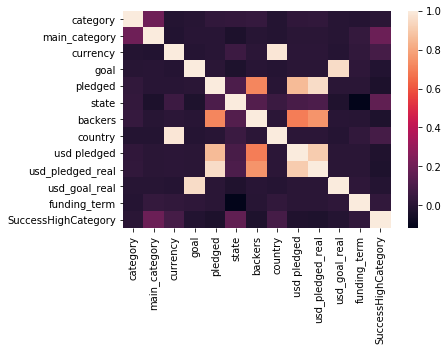

In [4]:
#カテゴリ変数を数値項目に変換

#LabelEncoderのインスタンスを生成
le = LabelEncoder()

#categoryに出てくるデータを覚えて、数値に変換
le = le.fit(df_ksproj['category'])
df_ksproj['category'] = le.transform(df_ksproj['category'])

#main_categoryに出てくるデータを覚えて、数値に変換
le = le.fit(df_ksproj['main_category'])
df_ksproj['main_category'] = le.transform(df_ksproj['main_category'])

#currencyに出てくるデータを覚えて、数値に変換
le = le.fit(df_ksproj['currency'])
df_ksproj['currency'] = le.transform(df_ksproj['currency'])

#stateに出てくるデータを覚えて、数値に変換
le = le.fit(df_ksproj['state'])
df_ksproj['state'] = le.transform(df_ksproj['state'])

#countryに出てくるデータを覚えて、数値に変換
le = le.fit(df_ksproj['country'])
df_ksproj['country'] = le.transform(df_ksproj['country'])

display(df_ksproj.head(5))

#カテゴリ変数を数値項目に変換したので、改めて相関関数とヒートマップで可視化
#相関関数を表示
display(df_ksproj.corr())

#ヒートマップを表示
sns.heatmap(df_ksproj.corr())


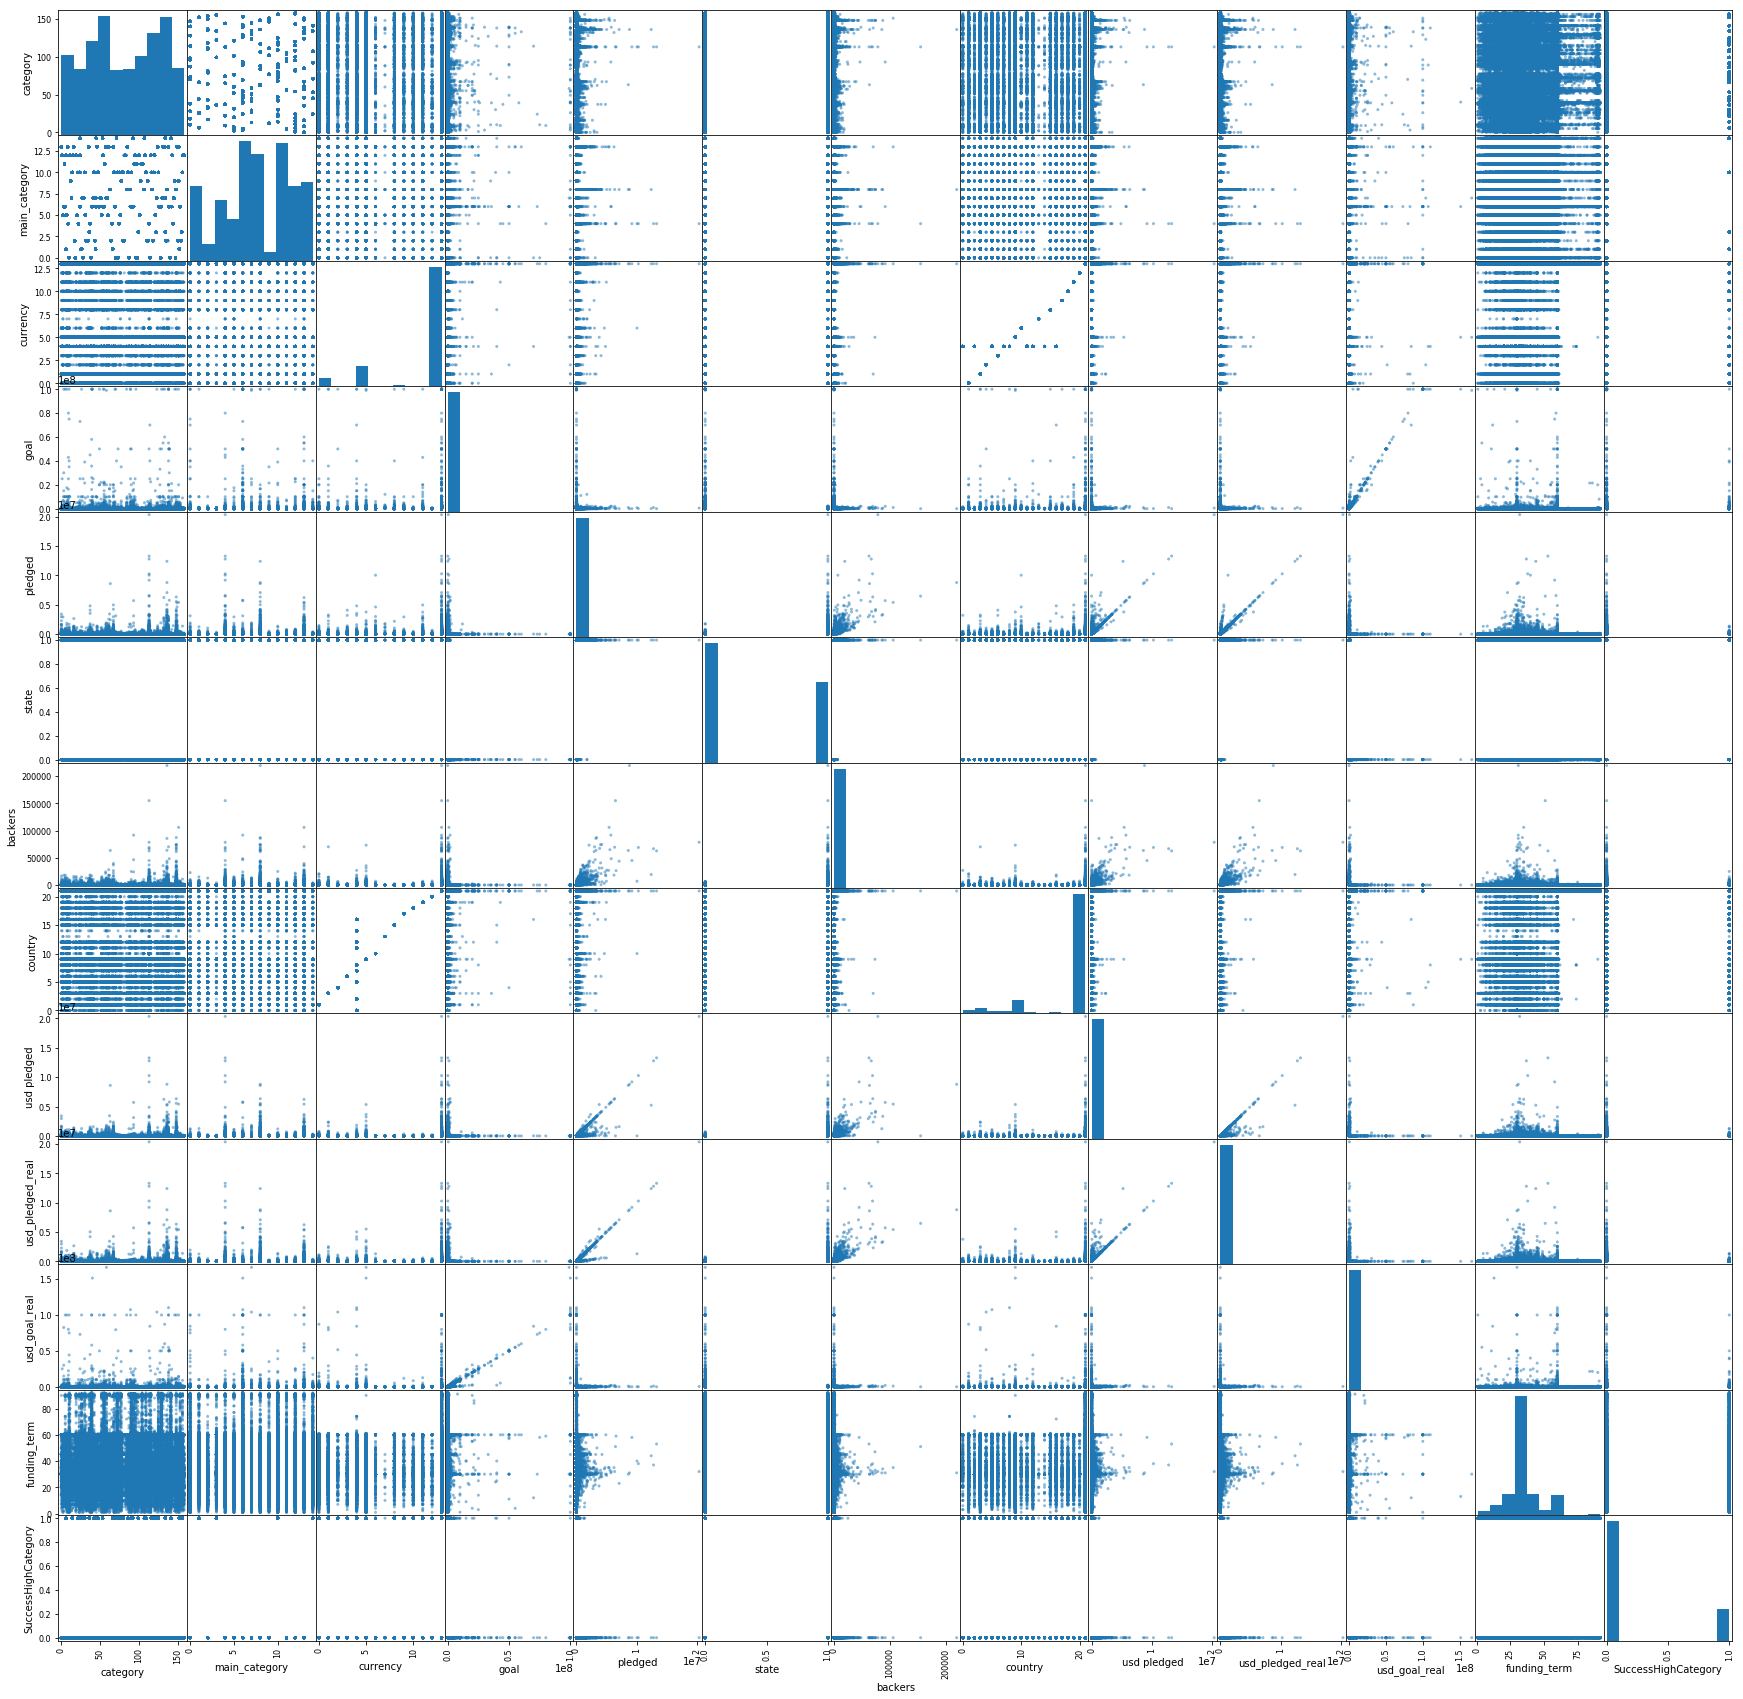

OSError: [Errno 22] Invalid argument: 'C:\temp\\scatter.jpg'

In [15]:
pd.plotting.scatter_matrix(df_ksproj, figsize=(30,30))
plt.show()
#plt.savefig('C:\temp\scatter.jpg')
#散布図から読み取れるものはなかった。。

In [16]:
#説明変数を選択する
#目的変数stateと相関がありそうな項目は以下の通り。しかしどれも相関度が低い。
#currency(0.059)、pledged(0.109)、backers(0.125)、usd_pledged(0.095)、usd_pledged_real(0.108)、SuccessHighCategory(0.162)
#この中からクラウドファンディング開始前にわからない項目は除外する
#backers:支援者の数は終わってみないと判断がつかない、Pledge??：これも集まった金額なので終わってみないと判断がつかない
#残った2つの項目を説明変数として使用する。
#Currency(Countoryはcurrencyと0.98の相関があるので省略する) SuccessHighCategory

#ロジスティック回帰実装
y = df_ksproj['state'].values
X = df_ksproj[['currency','SuccessHighCategory']].values

#学習データと予測データに分割する(80%:学習データ 20%:予測データ)
#分割の参考サイト⇒https://qiita.com/terapyon/items/8f8d3518ee8eeb4f96b2
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=1)

#loss:使用する損失関数 log⇒ロジスティック回帰、確率的分類子
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234)
#学習用データを使って学習する
clf.fit(X_train, y_train)

#ラベルを予測
#y_pred = clf.predict(X)
#学習用データでの予測
y_train_pred = clf.predict(X_train)
#予測用データでの予測
y_val_pred = clf.predict(X_val)

#正答率を計算
#accuracy =  accuracy_score(y, y_pred)
#print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))
train_score = accuracy_score(y_train, y_train_pred)
val_score = accuracy_score(y_val, y_val_pred)

#Precision, Recall, F1-scoreを計算
#precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)
train_precision, train_recall, train_f1_score, _ = precision_recall_fscore_support(y_train, y_train_pred)
val_precision, val_recall, val_f1_score, _ = precision_recall_fscore_support(y_val, y_val_pred)

print('学習用データでの正答率（Accuracy） = {:.3f}%'.format(100 * train_score))
print('学習用データでの適合率（Precision） = {:.3f}%'.format(100 * train_precision[0]))
print('学習用データでの再現率（Recall） = {:.3f}%'.format(100 * train_recall[0]))
print('学習用データでのF1値（F1-score） = {:.3f}%'.format(100 * train_f1_score[0]))

print('予測用データでの正答率（Accuracy） = {:.3f}%'.format(100 * val_score))
print('予測用データでの適合率（Precision） = {:.3f}%'.format(100 * val_precision[0]))
print('予測用データでの再現率（Recall） = {:.3f}%'.format(100 * val_recall[0]))
print('予測用データでのF1値（F1-score） = {:.3f}%'.format(100 * val_f1_score[0]))

#初回の実行結果
#学習用データでの正答率（Accuracy） = 62.080%
#学習用データでの適合率（Precision） = 63.607%
#学習用データでの再現率（Recall） = 85.095%
#学習用データでのF1値（F1-score） = 72.799%
#予測用データでの正答率（Accuracy） = 62.239%
#予測用データでの適合率（Precision） = 63.657%
#予測用データでの再現率（Recall） = 85.323%
#予測用データでのF1値（F1-score） = 72.915%


C:\Users\PC17001X\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


学習用データでの正答率（Accuracy） = 62.080%
学習用データでの適合率（Precision） = 63.607%
学習用データでの再現率（Recall） = 85.095%
学習用データでのF1値（F1-score） = 72.799%
予測用データでの正答率（Accuracy） = 62.239%
予測用データでの適合率（Precision） = 63.657%
予測用データでの再現率（Recall） = 85.323%
予測用データでのF1値（F1-score） = 72.915%


##### ◆2019/08/31  
　モデル：ロジスティック回帰  
　データ：除外⇒NaN有 stateがsuccessful/failed以外   
　目的変数：state  
　説明変数：currency SuccessHighCategory(成功率が50%以上のmain_category)  
　学習用データでの正答率（Accuracy） = 62.080%  
　学習用データでの適合率（Precision） = 63.607%  
　学習用データでの再現率（Recall） = 85.095%  
　学習用データでのF1値（F1-score） = 72.799%  
　予測用データでの正答率（Accuracy） = 62.239%  
　予測用データでの適合率（Precision） = 63.657%  
　予測用データでの再現率（Recall） = 85.323%  
　予測用データでのF1値（F1-score） = 72.915%  
   
　Accuracyが62%と低い。メインカテゴリの成功率の高さを説明変数で使うのはいいと考えるが、  
　通貨種類でクラウドファンディングが成功/失敗に影響は考えずらい。次回は違う項目を説明変数に使ってみる。  
 